Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV

Import datasets

In [2]:
train = pd.read_csv('../datasets/train_clean.csv')
test = pd.read_csv('../datasets/test_clean.csv')

X_train = pd.read_csv('../datasets/X_train.csv')
X_hold = pd.read_csv('../datasets/X_hold.csv')

y_train = pd.read_csv('../datasets/y_train.csv')
y_hold = pd.read_csv('../datasets/y_hold.csv')

y_train = y_train['SalePrice']

# Finalizing model for testing (train + holdout)

## Scaling

We need to drop categorical features and scale the numerical features before we can add the categorical features back.

In [3]:
cat_cols = X_train.select_dtypes(include=['object']).columns

X_train_num = X_train.drop(columns=cat_cols)
X_hold_num = X_hold.drop(columns=cat_cols)

num_cols = X_train.select_dtypes(exclude=['object']).columns

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_num[num_cols[1:]])
X_hold_scaled = ss.transform(X_hold_num[num_cols[1:]])

df_X_train = pd.DataFrame(X_train_scaled)
df_X_train.columns = num_cols[1:]

df_X_hold = pd.DataFrame(X_hold_scaled)
df_X_hold.columns = num_cols[1:]

X_train_scaled = pd.concat([df_X_train, X_train[['Id']].reset_index(drop=True)], axis=1)
X_hold_scaled = pd.concat([df_X_hold, X_hold[['Id']].reset_index(drop=True)], axis=1)

## Categorical feature selection for model

In [4]:
X_train_cat = X_train[cat_cols]
X_hold_cat = X_hold[cat_cols]

`MSZoning`

<AxesSubplot:xlabel='MSZoning', ylabel='SalePrice'>

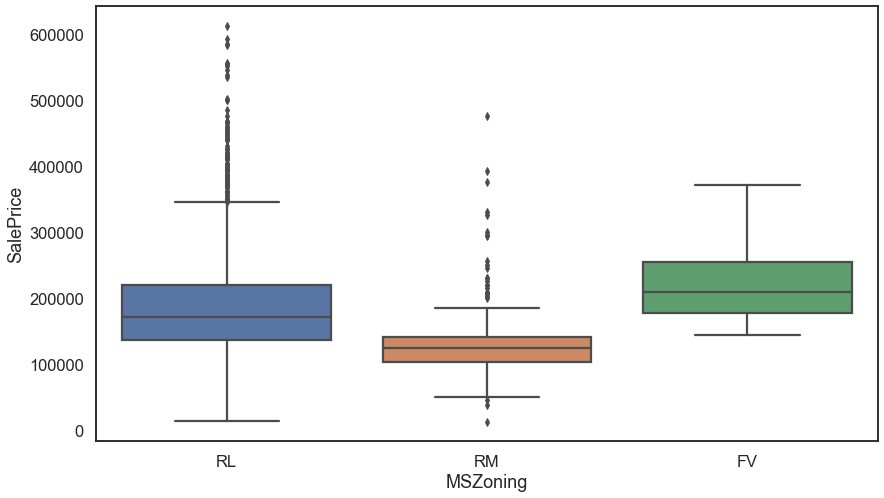

In [5]:
plt.figure(figsize=(14,8))
sns.boxplot(x=train['MSZoning'], y=train['SalePrice'])

In [6]:
MSZoning_X_train = pd.get_dummies(X_train_cat['MSZoning'], drop_first=True, prefix='MSZoning')
MSZoning_X_hold = pd.get_dummies(X_hold_cat['MSZoning'], drop_first=True, prefix='MSZoning')

X_train_scaled = pd.concat([X_train_scaled, MSZoning_X_train.reset_index(drop=True)], axis=1)
X_hold_scaled = pd.concat([X_hold_scaled, MSZoning_X_hold.reset_index(drop=True)], axis=1)

`Foundation`

<AxesSubplot:xlabel='Foundation', ylabel='SalePrice'>

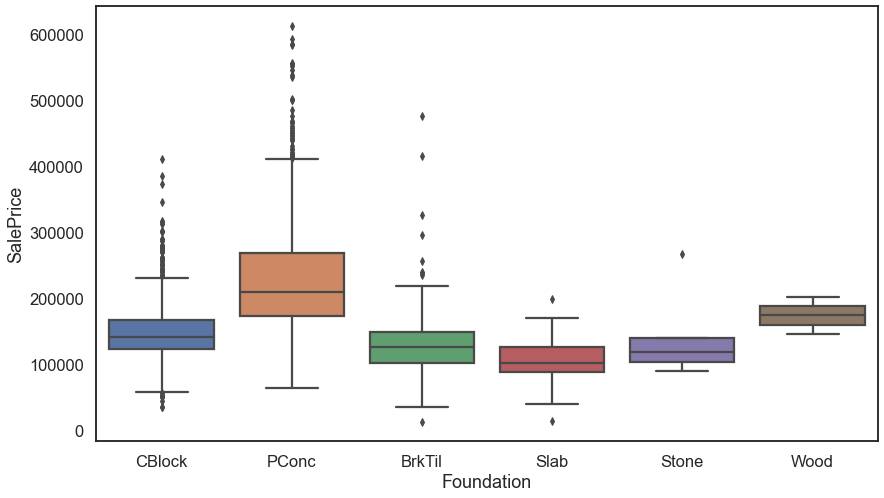

In [7]:
plt.figure(figsize=(14,8))
sns.boxplot(x=train['Foundation'], y=train['SalePrice'])

In [8]:
Foundation_X_train = pd.get_dummies(X_train_cat['Foundation'], drop_first=True, prefix='Foundation')
Foundation_X_hold = pd.get_dummies(X_hold_cat['Foundation'], drop_first=True, prefix='Foundation')

X_train_scaled = pd.concat([X_train_scaled, Foundation_X_train.reset_index(drop=True)], axis=1)
X_hold_scaled = pd.concat([X_hold_scaled, Foundation_X_hold.reset_index(drop=True)], axis=1)

# Modelling

## Hold out set

This section is used for me to control the features to add/remove from my model. As there were iterations already done by Lasso regression, only top 30 features were selected.

In [9]:
cols_to_drop = [
    '1stFlrSF',
    'ScreenPorch',
    'BsmtFullBath',
    'TotRmsAbvGrd',
    'LandContour',
    'LotArea',
    'BsmtFinType1',
    'YearsSinceRemod',
    'PoolArea',
    'HeatingQC',
    'WoodDeckSF',
    'Functional',
    'FullBath',
    'GarageYrBlt',
    'YearRemod/Add',
    'YearBuilt',
    'OpenPorchSF',
    'GarageCond',
    'PavedDrive',
    'BsmtFinType2',
    'EnclosedPorch',
    '3SsnPorch',
    'LotShape',
    'MoSold',
    'YrSold',
    'GarageQual',
    'LandSlope',
    'Utilities',
    'GarageFinish',
    'BsmtFinSF2',
    'ExterCond',
    'OverallCond',
    'KitchenAbvGr',
    'BedroomAbvGr',
    'HalfBath',
]

In [10]:
X_train_model = X_train_scaled.drop(columns=['Id'])
X_hold_model = X_hold_scaled.drop(columns=['Id'])

X_train_model = X_train_model.drop(columns=cols_to_drop)
X_hold_model = X_hold_model.drop(columns=cols_to_drop)

### Linear regression

In [11]:
lr = LinearRegression()
lr.fit(X_train_model, y_train)

LinearRegression()

In [12]:
cross_val_score(lr, X_train_model, y_train, scoring='neg_root_mean_squared_error').mean()

-35669.60426877133

In [13]:
cross_val_score(lr, X_hold_model, y_hold, scoring='neg_root_mean_squared_error').mean()

-27906.77487250042

In [14]:
lr_coefs = pd.DataFrame({'variable':X_train_model.columns,
                            'coef':lr.coef_,
                            'abs_coef':np.abs(lr.coef_)})

lr_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lr_coefs.head(50)

,variable,coef,abs_coef
14,GrLivArea,19819.652360,19819.652360
27,Foundation_Slab,19104.703494,19104.703494
2,OverallQual,17736.395359,17736.395359
28,Foundation_Stone,13627.673780,13627.673780
29,Foundation_Wood,11312.726165,11312.726165
16,KitchenQual,9653.168291,9653.168291
4,ExterQual,9583.394921,9583.394921
5,BsmtQual,9501.244444,9501.244444
21,total_sqft,9219.758078,9219.758078
0,MSSubClass,-8865.101132,8865.101132


### Lasso

In [15]:
lasso_model = LassoCV(n_alphas=100, cv=5)
lasso_model.fit(X_train_model, y_train)

LassoCV(cv=5)

In [16]:
lasso_model.alpha_

2400.513599233821

In [17]:
lasso = Lasso(lasso_model.alpha_)
lasso.fit(X_train_model, y_train)

Lasso(alpha=2400.513599233821)

In [18]:
cross_val_score(lasso, X_train_model, y_train, scoring='neg_root_mean_squared_error').mean()

-34988.942195016876

In [19]:
cross_val_score(lasso, X_hold_model, y_hold, scoring='neg_root_mean_squared_error').mean()

-27663.21716170716

In [20]:
lasso_coefs = pd.DataFrame({'variable':X_train_model.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(50)

,variable,coef,abs_coef
2,OverallQual,18498.797425,18498.797425
14,GrLivArea,17053.305814,17053.305814
4,ExterQual,10124.689495,10124.689495
16,KitchenQual,9221.341495,9221.341495
21,total_sqft,6305.641900,6305.641900
7,BsmtExposure,6033.469339,6033.469339
8,BsmtFinSF1,5641.947076,5641.947076
0,MSSubClass,-5460.267739,5460.267739
18,GarageCars,5322.773876,5322.773876
20,MiscVal,-4307.850293,4307.850293


### Ridge

In [21]:
ridge_alphas = np.logspace(0, 5, 200)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=5)
optimal_ridge.fit(X_train_model, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.05956018e+00, 1.12266777e+00, 1.18953407e+00,
       1.26038293e+00, 1.33545156e+00, 1.41499130e+00, 1.49926843e+00,
       1.58856513e+00, 1.68318035e+00, 1.78343088e+00, 1.88965234e+00,
       2.00220037e+00, 2.12145178e+00, 2.24780583e+00, 2.38168555e+00,
       2.52353917e+00, 2.67384162e+00, 2.83309610e+00, 3.00183581e+00,
       3.18062569e+00, 3.37006433e+0...
       2.64308149e+04, 2.80050389e+04, 2.96730241e+04, 3.14403547e+04,
       3.33129479e+04, 3.52970730e+04, 3.73993730e+04, 3.96268864e+04,
       4.19870708e+04, 4.44878283e+04, 4.71375313e+04, 4.99450512e+04,
       5.29197874e+04, 5.60716994e+04, 5.94113398e+04, 6.29498899e+04,
       6.66991966e+04, 7.06718127e+04, 7.48810386e+04, 7.93409667e+04,
       8.40665289e+04, 8.90735464e+04, 9.43787828e+04, 1.00000000e+05]),
        cv=5)

In [22]:
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge.fit(X_train_model, y_train)

Ridge(alpha=488.02515836544336)

In [23]:
cross_val_score(ridge, X_train_model, y_train, scoring='neg_root_mean_squared_error').mean()

-34635.73368244312

In [24]:
cross_val_score(ridge, X_hold_model, y_hold, scoring='neg_root_mean_squared_error').mean()

-30786.616298110028

In [25]:
ridge_coefs = pd.DataFrame({'variable':X_train_model.columns,
                            'coef':ridge.coef_,
                            'abs_coef':np.abs(ridge.coef_)})

ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)

ridge_coefs.head(40)

,variable,coef,abs_coef
2,OverallQual,12559.069621,12559.069621
14,GrLivArea,10530.685350,10530.685350
16,KitchenQual,9250.967601,9250.967601
4,ExterQual,9224.735133,9224.735133
21,total_sqft,8328.767850,8328.767850
7,BsmtExposure,6193.259685,6193.259685
5,BsmtQual,5486.625109,5486.625109
17,Fireplaces,5424.991952,5424.991952
0,MSSubClass,-5272.937462,5272.937462
18,GarageCars,4993.736613,4993.736613


## Test set

### Scale dataset (train + test)

In [26]:
cat_cols = train.select_dtypes(include=['object']).columns

train_cat = train[cat_cols]
test_cat = test[cat_cols]

train_num = train.drop(columns=cat_cols)
test_num = test.drop(columns=cat_cols)

num_cols = train.select_dtypes(exclude=['object']).columns
num_cols = num_cols.drop('SalePrice')

In [27]:
ss = StandardScaler()
train_scaled = ss.fit_transform(train_num[num_cols[1:]])
test_scaled = ss.transform(test_num[num_cols[1:]])

df_train_scaled = pd.DataFrame(train_scaled)
df_train_scaled.columns = num_cols[1:]

df_test_scaled = pd.DataFrame(test_scaled)
df_test_scaled.columns = num_cols[1:]

train_scaled = pd.concat([df_train_scaled, train[['Id']].reset_index(drop=True)], axis=1)
test_scaled = pd.concat([df_test_scaled, test[['Id']].reset_index(drop=True)], axis=1)

Concat dummy variables for `MSZoning` and `Foundation`.

In [28]:
MSZoning_X_train = pd.get_dummies(train['MSZoning'], drop_first=True, prefix='MSZoning')
MSZoning_X_test = pd.get_dummies(test['MSZoning'], drop_first=True, prefix='MSZoning')

train_scaled = pd.concat([train_scaled, MSZoning_X_train.reset_index(drop=True)], axis=1)
test_scaled = pd.concat([test_scaled, MSZoning_X_test.reset_index(drop=True)], axis=1)

Foundation_X_train = pd.get_dummies(train['Foundation'], drop_first=True, prefix='Foundation')
Foundation_X_test = pd.get_dummies(test['Foundation'], drop_first=True, prefix='Foundation')

train_scaled = pd.concat([train_scaled, Foundation_X_train.reset_index(drop=True)], axis=1)
test_scaled = pd.concat([test_scaled, Foundation_X_test.reset_index(drop=True)], axis=1)

### Feature controlling

In [29]:
y_train = train['SalePrice']

In [30]:
X_train_model_final = train_scaled.drop(columns=['Id'])
X_test_model_final = test_scaled.drop(columns=['Id'])

X_train_model_final = X_train_model_final.drop(columns=cols_to_drop)
X_test_model_final = X_test_model_final.drop(columns=cols_to_drop)

### Linear regression

In [31]:
lr = LinearRegression()
lr.fit(X_train_model_final, y_train)

LinearRegression()

In [32]:
cross_val_score(lr, X_train_model_final, y_train, scoring='neg_root_mean_squared_error').mean()

-33289.93616919753

In [33]:
lr_coefs = pd.DataFrame({'variable':X_train_model_final.columns,
                            'coef':lr.coef_,
                            'abs_coef':np.abs(lr.coef_)})

lr_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lr_coefs.head(50)

,variable,coef,abs_coef
28,Foundation_Stone,21313.459079,21313.459079
14,GrLivArea,19725.264409,19725.264409
2,OverallQual,17895.253285,17895.253285
27,Foundation_Slab,17393.972833,17393.972833
21,total_sqft,10910.946651,10910.946651
16,KitchenQual,9010.382598,9010.382598
4,ExterQual,8877.374128,8877.374128
5,BsmtQual,8486.833615,8486.833615
0,MSSubClass,-8103.463265,8103.463265
7,BsmtExposure,6996.891553,6996.891553


### Lasso

In [34]:
lasso_model = LassoCV(n_alphas=100, cv=5)
lasso_model.fit(X_train_model_final, y_train)

LassoCV(cv=5)

In [35]:
lasso_model.alpha_

838.9133333317393

In [36]:
lasso = Lasso(lasso_model.alpha_)
lasso.fit(X_train_model_final, y_train)

Lasso(alpha=838.9133333317393)

In [37]:
cross_val_score(lasso, X_train_model_final, y_train, scoring='neg_root_mean_squared_error').mean()

-32997.98596395317

In [38]:
lasso_coefs = pd.DataFrame({'variable':X_train_model_final.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs

,variable,coef,abs_coef
14,GrLivArea,20281.113482,20281.113482
2,OverallQual,17945.513542,17945.513542
4,ExterQual,9371.171041,9371.171041
16,KitchenQual,9039.204730,9039.204730
0,MSSubClass,-7302.036685,7302.036685
8,BsmtFinSF1,7142.124783,7142.124783
7,BsmtExposure,6620.851430,6620.851430
3,MasVnrArea,5345.270095,5345.270095
20,MiscVal,-5228.980800,5228.980800
21,total_sqft,4749.231239,4749.231239


### Ridge

In [39]:
ridge_alphas = np.logspace(0, 5, 200)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=5)
optimal_ridge.fit(X_train_model_final, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.05956018e+00, 1.12266777e+00, 1.18953407e+00,
       1.26038293e+00, 1.33545156e+00, 1.41499130e+00, 1.49926843e+00,
       1.58856513e+00, 1.68318035e+00, 1.78343088e+00, 1.88965234e+00,
       2.00220037e+00, 2.12145178e+00, 2.24780583e+00, 2.38168555e+00,
       2.52353917e+00, 2.67384162e+00, 2.83309610e+00, 3.00183581e+00,
       3.18062569e+00, 3.37006433e+0...
       2.64308149e+04, 2.80050389e+04, 2.96730241e+04, 3.14403547e+04,
       3.33129479e+04, 3.52970730e+04, 3.73993730e+04, 3.96268864e+04,
       4.19870708e+04, 4.44878283e+04, 4.71375313e+04, 4.99450512e+04,
       5.29197874e+04, 5.60716994e+04, 5.94113398e+04, 6.29498899e+04,
       6.66991966e+04, 7.06718127e+04, 7.48810386e+04, 7.93409667e+04,
       8.40665289e+04, 8.90735464e+04, 9.43787828e+04, 1.00000000e+05]),
        cv=5)

In [40]:
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge.fit(X_train_model_final, y_train)

Ridge(alpha=325.508859983506)

In [41]:
cross_val_score(ridge, X_train_model_final, y_train, scoring='neg_root_mean_squared_error').mean()

-32935.83089329673

In [42]:
ridge_coefs = pd.DataFrame({'variable':X_train_model_final.columns,
                            'coef':ridge.coef_,
                            'abs_coef':np.abs(ridge.coef_)})

ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)

ridge_coefs.head(40)

,variable,coef,abs_coef
2,OverallQual,14381.732586,14381.732586
14,GrLivArea,12551.310663,12551.310663
21,total_sqft,9475.576084,9475.576084
16,KitchenQual,9178.843025,9178.843025
4,ExterQual,9046.131993,9046.131993
7,BsmtExposure,6328.476549,6328.476549
0,MSSubClass,-6026.829218,6026.829218
3,MasVnrArea,5883.127234,5883.127234
5,BsmtQual,5430.548332,5430.548332
17,Fireplaces,5290.485197,5290.485197


### Predicting and submitting to Kaggle

Overall, all 3 models gave very close scores. I've decided to go with Lasso for my preferred regularization method as that was the model which I utilized to eliminate features. 

In [43]:
y_preds = lasso.predict(X_test_model_final)

In [44]:
submit = pd.DataFrame()
submit['Id'] = test['Id']
submit['SalePrice'] = y_preds
submit.sort_values(by='Id', inplace=True)
submit
submit.to_csv('../datasets/submit.csv', index=False)

![image info](../images/kaggle3.png)

# Conclusion

Intuitively, age old mantras of location, size and quality still play an important role in determining sale price.

Below are the top 10 features from the model that mattered the most to sale price:  

1. Above grade (ground) living area square feet
    - 1 square feet increase results in 20281 price increment  
2. Overall material and finish of the house
    - 1 additional unit score results in 17845 price increment 
3. Quality of the material on the exterior  
    - 1 additional unit score results in 9371 price increment
4. Kitchen quality
    - 1 additional unit score results in 9039 price increment
5. Type 1 finished square feet of basement
    - 1 square feet increase results in 7142 price increment
6. Exposure to walkout or garden level walls
    - 1 additional unit score results in 6620 price increment
7. Masonry veneer type
    - 1 additional unit score results in 5345 price increment
8. Interior square feet of house
    - 1 additional unit score results in 4749 price increment
9. Height of basement
    - 1 additional unit score results in 4708 price increment
10. Number of fireplaces
    - 1 additional unit results in 4235 price increment
    
If you're intending to sell your house, you can consider remodelling your house (areas to consider include house exterior or quality of kitchen). You can also throw in additional fireplaces as well.

Lasso regression was used in the end as it was the main model that helped to reduce the features as well as produced the best score amongst all the models. The final Kaggle score was 31165, and the baseline to beat was 80000, which signals that the model is significantly effective. 

To summarize, this model placed more emphasis on size and quality of the house, as opposed to locational features. That could be a follow up experiment to see if additional locational features would be able to generate a better prediction. 

![image info](../images/conclusion2.png)